In [1]:
import torch
import einops
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from dino import DINO
import pytorch_lightning as pl

%matplotlib inline

In [2]:
pl.seed_everything(72)

Global seed set to 72


72

In [3]:
xs = torch.load("ckpts/dino_4.ckpt", map_location="cpu")

In [4]:
xs.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [5]:
model = DINO.load_from_checkpoint("ckpts/dino_4.ckpt", map_location="cpu")

In [6]:
conf = OmegaConf.load("configs/local/edge.yml")["data"]

In [7]:
from save_features import LabelledDataset, save_features
from torch.utils.data import DataLoader

In [8]:
train_classes = ["n02687172", "n04251144", "n02823428", "n03676483", "n03400231"]
test_classes = ["n03272010", "n07613480", "n03775546", "n03127925", "n04146614"]
trainset = LabelledDataset('miniimagenet', conf["datapath"],
                           'train', train_classes)
testset = LabelledDataset('miniimagenet', conf["datapath"],
                          'test', test_classes)
trainloader = DataLoader(trainset, shuffle=False, batch_size=100)
testloader = DataLoader(testset, shuffle=False, batch_size=100)

In [9]:
fe = save_features(model.student_backbone, trainloader, "dino_student_features.hdf5")

0/30
10/30
20/30


In [10]:
del fe

In [11]:
fe = save_features(model.student_backbone, testloader, "dino_student_test_features.hdf5")

0/30
10/30
20/30


In [12]:
del fe

In [13]:
import h5py

In [14]:
f_train_cnn = h5py.File('dino_student_features.hdf5', 'r')
f_test_cnn = h5py.File('dino_student_test_features.hdf5', 'r')

In [15]:
X_cnn_5_train = f_train_cnn['all_feats']
y_cnn_5_train = f_train_cnn['all_labels']
X_cnn_5_test = f_test_cnn['all_feats']
y_cnn_5_test = f_test_cnn['all_labels']

In [16]:
import random
import warnings
import umap
from sklearn.manifold import TSNE

In [17]:
train_protoclr_idx = random.sample(range(len(y_cnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_5_train = X_cnn_5_train[train_protoclr_idx]
y_cnn_5_train = y_cnn_5_train[train_protoclr_idx]

test_protoclr_idx = random.sample(range(len(y_cnn_5_test)),500)
test_protoclr_idx.sort()

X_cnn_5_test = X_cnn_5_test[test_protoclr_idx]
y_cnn_5_test = y_cnn_5_test[test_protoclr_idx]

In [18]:
um = TSNE(n_components=2, random_state=0)
X_cnn_2d_train = um.fit_transform(einops.rearrange(X_cnn_5_train, "b c h w -> b (c h w)"))

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
um = TSNE(n_components=2, random_state=0)
X_cnn_2d_test = um.fit_transform(einops.rearrange(X_cnn_5_test, "b c h w -> b (c h w)"))

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
def plot2d(X_2d, y,colors=None, title=None, save_as=None):
    target_ids = range(5)
    labels_train = ["Class {}".format(i) for i in range(1,6)]

    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(11.7,8.27))
    ax = fig.add_subplot(111)
    #colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
    
    markers = "o","D","*","^","P"
    #print(len(colors))
    for i, c, label, marker in zip(target_ids, colors, labels_train, markers):
        ax.scatter(X_2d[y == i, 0],
                   X_2d[y == i, 1], 
                   c=c, label=label, marker=marker)
    #plt.legend()
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    #plt.legend(loc='lower right')
    if save_as:
        plt.savefig(save_as, bbox_inches = 'tight',
            pad_inches = 0)
    if title:
        plt.title(title)
    plt.show()

In [21]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [22]:
sns.set_theme()

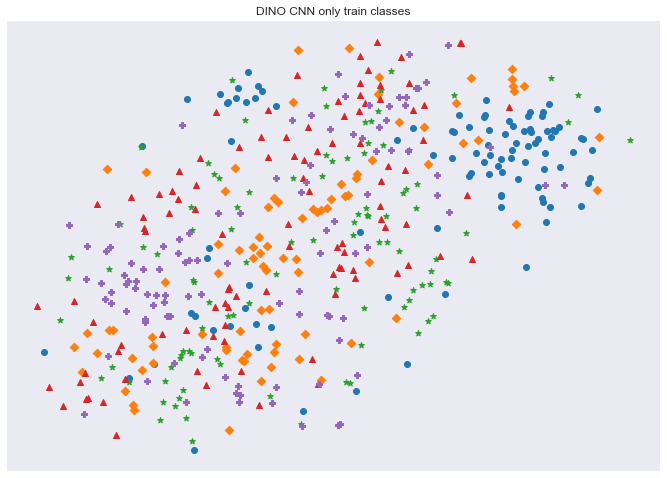

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2d(X_2d=X_cnn_2d_train, 
           y=y_cnn_5_train,
           colors=colors[:5],
           title="DINO CNN only train classes")

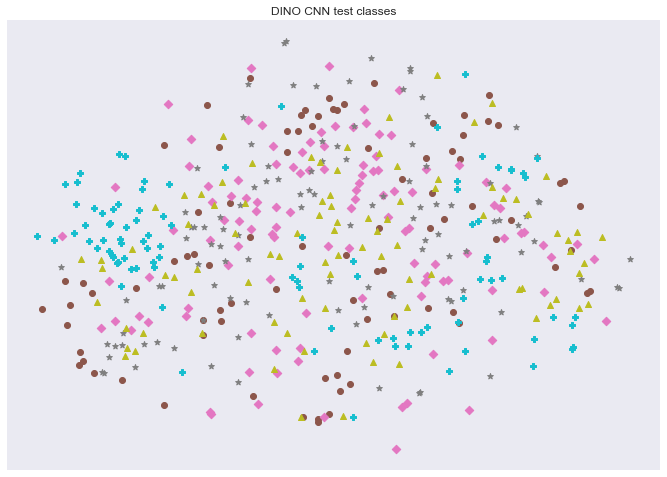

In [24]:
plot2d(X_2d=X_cnn_2d_test, 
       y=y_cnn_5_test,
       colors=colors[5:],
       title="DINO CNN test classes")